# Accumulation investment simulation
Excahnge rate is NOT included!!

In [35]:
nisa_capacity = 18000000
monthly_investment_until_fill_nisa = 18000000
monthly_investment_after_fill_nisa = 0
accumulation_year = 35
trust_fee = 0.01  # percentage per year

monthly_withdrawal_after_retirement = 100000
year_after_retirement = 40

# ticker_symbol = "ACWI"  # All Country World Index
ticker_symbol = "^GSPC"  # S&P 500
# ticker_symbol = "^N225"  # Nikkei 225
# ticker_symbol = "SCHD"  # Schwab US Dividend Equity ETF
# ticker_symbol = "^RUT"  # Russell 2000

monte_carlo_simulation_time = 100000

## Index history and score

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

index_data = yf.download(ticker_symbol, period="max")
index_data

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^GSPC']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,


In [37]:
# Resample to monthly data and get Open and Close
monthly_index = index_data.resample('ME').agg({('Open', ticker_symbol): 'first', ('Close', ticker_symbol): 'last'})
# Calculate the monthly return
monthly_index['Return'] = monthly_index['Close'].pct_change()
# Drop the first and last row, which is the current month
monthly_index = monthly_index.iloc[1:-1]
# monthly_index.to_csv('monthly_index.csv')
monthly_index

Price,Open,Close,Return
Ticker,^GSPC,^GSPC,
Date,,,


ValueError: zero-size array to reduction operation fmin which has no identity

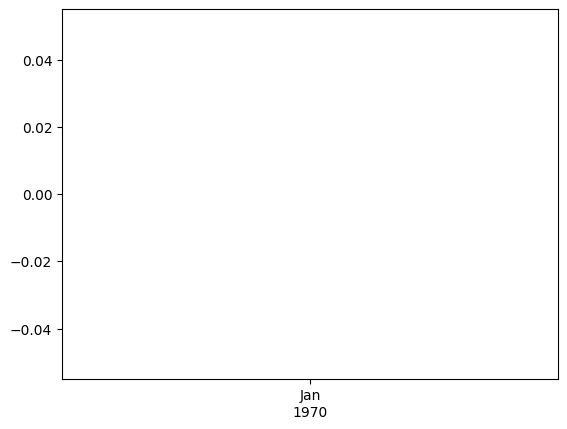

In [38]:
# Visualize the monthly index chart
monthly_index['Close'].plot()
plt.show()
monthly_index['Close'].plot(logy=True)
plt.show()

# Calculate the mean and standard deviation of the monthly return
mean_monthly_return = monthly_index['Return'].mean()
std_monthly_return = monthly_index['Return'].std()
print("mean: ", mean_monthly_return)
print("std: ", std_monthly_return)

# Visualize the monthly return histogram
monthly_index['Return'].hist(bins=100, density=True)
# Overlay the normal distribution according to the mean and standard deviation
x = np.linspace(-0.4, 0.4, 1000)
y = 1 / (std_monthly_return * np.sqrt(2 * np.pi)) * np.exp(- (x - mean_monthly_return) ** 2 / (2 * std_monthly_return ** 2))
plt.plot(x, y, color='r')
plt.title('Monthly Return Histogram')
plt.show()


## Monte Carlo simulation until retirement

In [ ]:
monthly_trust_fee = (trust_fee / 100) ** (1/12)
print("Monthly Trust Fee: ", monthly_trust_fee)
result = []
for n in range(monte_carlo_simulation_time):
    accumulated_principal = 0
    market_value = 0
    investment_return = 0
    for year in range(accumulation_year):
        for month in range(12):
            if accumulated_principal < nisa_capacity:
                accumulated_principal += monthly_investment_until_fill_nisa
                market_value += monthly_investment_until_fill_nisa
            else:
                accumulated_principal += monthly_investment_after_fill_nisa
                market_value += monthly_investment_after_fill_nisa

            market_value *= (1 + np.random.normal(mean_monthly_return, std_monthly_return))
            investment_return *= (1 + np.random.normal(mean_monthly_return, std_monthly_return) - monthly_trust_fee)
            
    result.append(investment_return)
result = pd.Series(result)
# print(result.mean())
# print(result.std())
print("Principal: ", accumulated_principal)
print("========================================")
print("Worst case: ", int(result.min()))
print("Bottom 1%: ", int(result.quantile(0.01)))
print("Bottom 2%: ", int(result.quantile(0.02)))
print("Bottom 3%: ", int(result.quantile(0.03)))
print("Bottom 4%: ", int(result.quantile(0.04)))
print("Bottom 5%: ", int(result.quantile(0.05)))
print("Bottom 10%: ", int(result.quantile(0.1)))
print("Bottom 20%: ", int(result.quantile(0.2)))
print("Bottom 30%: ", int(result.quantile(0.3)))
print("Median: ", int(result.quantile(0.5)))
print("Top 10%: ", int(result.quantile(0.9)))

Principal:  18000000
Worst case:  1121030
Bottom 1%:  11467271
Bottom 2%:  15500538
Bottom 3%:  18622841
Bottom 4%:  21601082
Bottom 5%:  24281007
Bottom 10%:  36292237
Bottom 20%:  58401009
Bottom 30%:  82564281
Median:  146263673
Top 10%:  596451684


## Monte Carlo simulation lifetime

In [ ]:
result = []
for n in range(monte_carlo_simulation_time):
    accumulated_principal = 0
    market_value = 0
    investment_return = 0
    for year in range(accumulation_year):
        for month in range(12):
            if accumulated_principal < nisa_capacity:
                accumulated_principal += monthly_investment_until_fill_nisa
                market_value += monthly_investment_until_fill_nisa
            else:
                accumulated_principal += monthly_investment_after_fill_nisa
                market_value += monthly_investment_after_fill_nisa

            market_value *= (1 + np.random.normal(mean_monthly_return, std_monthly_return))
            investment_return *= (1 + np.random.normal(mean_monthly_return, std_monthly_return) - monthly_trust_fee)

    total_withdrawal = 0        
    for year in range(year_after_retirement):
        for month in range(12):
            total_withdrawal -= monthly_withdrawal_after_retirement
            market_value -= monthly_withdrawal_after_retirement
            if market_value > 0:
                market_value *= (1 + np.random.normal(mean_monthly_return, std_monthly_return))
                investment_return *= (1 + np.random.normal(mean_monthly_return, std_monthly_return) - monthly_trust_fee)
            else:
                # Bankrupt
                market_value = market_value
                investment_return = investment_return

    result.append(investment_return)
result = pd.Series(result)
# print(result.mean())
# print(result.std())
print("Principal: ", accumulated_principal)
print("total_withdrawal: ", total_withdrawal)
print("========================================")
print("Worst case: ", int(result.min()))
print("Bottom 1%: ", int(result.quantile(0.01)))
print("Bottom 2%: ", int(result.quantile(0.02)))
print("Bottom 3%: ", int(result.quantile(0.03)))
print("Bottom 4%: ", int(result.quantile(0.04)))
print("Bottom 5%: ", int(result.quantile(0.05)))
print("Bottom 10%: ", int(result.quantile(0.1)))
print("Bottom 20%: ", int(result.quantile(0.2)))
print("Bottom 30%: ", int(result.quantile(0.3)))
print("Median: ", int(result.quantile(0.5)))
print("Top 10%: ", int(result.quantile(0.9)))

Principal:  18000000
total_withdrawal:  -48000000
Worst case:  -47544555
Bottom 1%:  -33892739
Bottom 2%:  -26896677
Bottom 3%:  -19651488
Bottom 4%:  -10526869
Bottom 5%:  1817382
Bottom 10%:  73579148
Bottom 20%:  252855054
Bottom 30%:  499104787
Median:  1353030048
Top 10%:  11900709486


## Monte Carlo simulation only after retirement

In [ ]:
initial_capital = 50000000



result = []
for n in range(monte_carlo_simulation_time):
    accumulated_principal = initial_capital
    market_value = initial_capital
    investment_return = initial_capital

    total_withdrawal = 0        
    for year in range(year_after_retirement):
        for month in range(12):
            total_withdrawal -= monthly_withdrawal_after_retirement
            market_value -= monthly_withdrawal_after_retirement
            if market_value > 0:
                market_value *= (1 + np.random.normal(mean_monthly_return, std_monthly_return))
                investment_return *= (1 + np.random.normal(mean_monthly_return, std_monthly_return) - monthly_trust_fee)
            else:
                # Bankrupt
                market_value = market_value

    result.append(investment_return)
result = pd.Series(result)
# print(result.mean())
# print(result.std())
print("Principal: ", accumulated_principal)
print("total_withdrawal: ", total_withdrawal)
print("========================================")
print("Worst case: ", int(result.min()))
print("Bottom 1%: ", int(result.quantile(0.01)))
print("Bottom 2%: ", int(result.quantile(0.02)))
print("Bottom 3%: ", int(result.quantile(0.03)))
print("Bottom 4%: ", int(result.quantile(0.04)))
print("Bottom 5%: ", int(result.quantile(0.05)))
print("Bottom 10%: ", int(result.quantile(0.1)))
print("Bottom 20%: ", int(result.quantile(0.2)))
print("Bottom 30%: ", int(result.quantile(0.3)))
print("Median: ", int(result.quantile(0.5)))
print("Top 10%: ", int(result.quantile(0.9)))

Principal:  50000000
total_withdrawal:  -48000000
Worst case:  -33647270
Bottom 1%:  -19707622
Bottom 2%:  -14090663
Bottom 3%:  -8835881
Bottom 4%:  -3555273
Bottom 5%:  2459468
Bottom 10%:  28961315
Bottom 20%:  84039867
Bottom 30%:  146649065
Median:  329896663
Top 10%:  1836923722
